In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt

# 以下の順で実装
## ・スケーラー
## ・テストデータオブジェクト
## ・パラメーターとモデルの互換オブジェクト
## ・チューニングオブジェクト向けのモデル定義
## ・チューニングオブジェクト

# 説明変数のスケーリングを個別に行う実装

In [29]:
from sklearn.preprocessing import StandardScaler

# ダミー変数を処理する事を回避するため平均と標準偏差の合計が指定値を下回る変数は処理しない
def getColIndex(_X,Names):
    ret  = []
    cols = _X.columns
    dic  = {}
    cnt = 0
    for col in cols:
        dic[col] = cnt
        cnt += 1
    for name in Names:
        if name in dic:
            ret.append(dic[name])
        else:
            ret.append(-1)
    return ret

class scaler:
    def __init__(self):
        ret = {}
    def do(self,_X_train,_X_test):
        return
    def convDecorr(self,_X_train = np.array([[]]),_X_test = np.array([[]])):
        ##  無相関化を行うための一連の処理
        cov = np.cov(_X_train, rowvar=0)        # 分散・共分散を求める
        _, S = np.linalg.eig(cov)               # 分散共分散行列の固有ベクトルを用いて
        decorrTrain = np.dot(S.T, _X_train.T).T #データを無相関化
        decorrTest  = np.dot(S.T, _X_test.T).T  #データを無相関化

        return [decorrTrain,decorrTest]

    def convStd(self,_X_train,_X_test):
        mean = _X_train.mean()
        std  = _X_train.std()
        X_train = ( _X_train - mean ) / std
        X_test  = ( _X_test  - mean ) / std
        return [X_train,X_test]
    def convMinMax(self,_X_train,_X_test):
        min   = _X_train.min()
        scale = _X_train.max() - min
        X_train = ( _X_train - min ) / scale
        X_test  = ( _X_test  - min ) / scale
        return [X_train,X_test]

class scaleOnlyLarge(scaler):
    def __init__(self,_large = 1):
        self.large = _large
        
    def do(self,_X_train,_X_test):
        for i in range(_X_train.shape[1]):
            if abs(_X_train[:,i].mean()) + _X_train[:,i].std()  > self.large:
                _X_train[:,i],_X_test[:,i] = self.convStd(_X_train[:,i],_X_test[:,i])

        ret = []
        ret.append(_X_train)
        ret.append(_X_test)
        return ret

class scaleOtherThanDummy(scaler):
    # ダミー変数を処理する事を回避するため、0か1のデータを避けてスケーリング
    def do(self,_X_train,_X_test):
        for i in range(_X_train.shape[1]):
            uniqueKey = np.unique(_X_train[:,i])
            if ((uniqueKey == 0) + (uniqueKey == 1)).min() == False:
                _X_train[:,i],_X_test[:,i] = self.convStd(_X_train[:,i],_X_test[:,i])

        ret = []
        ret.append(_X_train)
        ret.append(_X_test)
        return ret

class scaleOrder(scaler):
    def __init__(self,_stdOrder = None,_mmOrder = [], _decorrOrder = []):
        self.stdOrder    = _stdOrder
        self.mmOrder     = _mmOrder
        if ( _decorrOrder != None ) & ( len(_decorrOrder) >= 2 ):
            self.decorrOrder = _decorrOrder
        else:
            self.decorrOrder = None
            
    def do(self,_X_train,_X_test):
        
        if self.decorrOrder != None:
            od = self.decorrOrder
            _X_train[:,od],_X_test[:,od] = self.convDecorr(_X_train[:,od],_X_test[:,od])
        
        loopIndexs = []
        if self.stdOrder != None:
            loopIndexs = self.stdOrder
        else:
            loopIndexs = range(_X_train.shape[1])
        
        for i in loopIndexs:
            uniqueKey = np.unique(_X_train[:,i])
            if ((uniqueKey == 0) + (uniqueKey == 1)).min() == False:
                _X_train[:,i],_X_test[:,i] = self.convStd(_X_train[:,i],_X_test[:,i])
                
        loopIndexs = []
        if self.mmOrder != None:
            loopIndexs = self.mmOrder
        for i in loopIndexs:
            uniqueKey = np.unique(_X_train[:,i])
            if ((uniqueKey == 0) + (uniqueKey == 1)).min() == False:
                _X_train[:,i],_X_test[:,i] = self.convMinMax(_X_train[:,i],_X_test[:,i])

        return [_X_train,_X_test]



# データに合わせたテスト実行クラスの実装

In [315]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold

class test:
    def __init__(self):
        self.columns = {"y":"","X":[""]}
        self.X_train = []
        self.X_test  = []
        self.y_train = []
        self.y_test  = []
        self.Random = -1
        self.Split  = -1
    
    def setRandom(self,_random):
        self.Random = _random

    def setSplit(self,_split):
        self.Split = _split
    
    def getRandom(self):
        return self.Random
    def getSplit(self):
        return self.Split
    
    def do(self,_model):
        return {"mse_train":0,"mse_test":0}

    def modelKick(self,_model,_X_train,_y_train,_X_test,_y_test):
        _model.fit(_X_train, _y_train)
        y_pred_train = _model.predict(_X_train)
        y_pred_test  = _model.predict(_X_test)
        mse_train = mean_squared_error(_y_train, y_pred_train)
        mse_test  = mean_squared_error(_y_test,  y_pred_test)
        return {"mse_train":mse_train,"mse_test":mse_test}
    
    def scaling(self,_X_train,_X_test):
        ret = []
        scaler = StandardScaler()
        scaler.fit(_X_train)
        ret.append(scaler.transform(_X_train))
        ret.append(scaler.transform(_X_test))
        return ret
    
    def getViewSet(self):
        ret = []
        ret_df = pd.DataFrame(self.y_train,columns=[self.columns["y"]])
        ret_df[self.columns["X"]] = pd.DataFrame(self.X_train)
        ret.append(ret_df)
        ret_df = pd.DataFrame(self.y_test,columns=[self.columns["y"]])
        ret_df[self.columns["X"]] = pd.DataFrame(self.X_test)
        ret.append(ret_df)
        return ret

    def plot(self,_colorRange=[0x003300,0xEE00EE]):
        # 標準化
        viewSet = self.getViewSet()

        colorset    = np.round(np.linspace(_colorRange[0],_colorRange[1],len(viewSet[0].columns)))
        color_codes = {}
        cnt         = 0
        for color in colorset:
            colorValue       = (int(color//0x10000),int(color//0x100%0x100),int(color%0x100))
            color_codes[cnt] = ('#%02X%02X%02X' % (colorValue[0],colorValue[1],colorValue[2]))
            cnt += 1

        colorIndexs = []
        cnt = 0
        first = True
        for view in viewSet:
            colorIndexs += [cnt] * len(view)
            cnt += 1
            if first == True:
                first = False
                viewALL = view
            else:
                viewALL = viewALL.append(view)

        colors = [color_codes[x] for x in colorIndexs]
        display(viewALL.describe())
        display(viewALL.info())
                               
        pd.plotting.scatter_matrix(viewALL, figsize=(12,12),color=colors)
        plt.show()
        sns.heatmap(viewALL.corr())
        plt.show()
        
class holdOutTest(test):
    def __init__(self,_X,_y,_random,scaler=None,_isSuffle=True):
        self.columns = {"y":_y.name,"X":list(_X.columns)}
        self.setRandom(_random)
        datas = train_test_split(np.array(_X), np.array(_y), test_size=0.2,shuffle=_isSuffle,random_state = _random)
        self.X_train = datas[0]
        self.X_test  = datas[1]
        self.y_train = datas[2]
        self.y_test  = datas[3]

        if scaler == None:
            self.X_train,self.X_test = self.scaling(self.X_train,self.X_test)
        else:
            self.X_train,self.X_test = scaler.do(self.X_train,self.X_test)
        
    def do(self,_model):
        return self.modelKick(_model,self.X_train,self.y_train,self.X_test,self.y_test)

class kFoldTest(test):
    def __init__(self,_X,_y,_split,_random,scaler=None,_isSuffle=True):
        self.columns = {"y":_y.name,"X":list(_X.columns)}
        self.setSplit(_split)
        self.setRandom(_random)

        self.split = _split
        splitter = KFold(n_splits=_split, shuffle=_isSuffle, random_state=_random)

        self.X_train = []
        self.y_train = []
        self.X_test  = []
        self.y_test  = []

        X = np.array(_X)
        y = np.array(_y)
        
        for train_idx, test_idx in splitter.split(X,y):

            X_train_k, y_train_k = X[train_idx], y[train_idx] #学習用データ
            X_test_k, y_test_k   = X[test_idx] , y[test_idx]  #テスト用データ

            if scaler == None:
                X_train_k,X_test_k = self.scaling(X_train_k,X_test_k)
            else:
                X_train_k,X_test_k = scaler.do(X_train_k,X_test_k)

            self.X_train.append(X_train_k)
            self.y_train.append(y_train_k)
            self.X_test.append(X_test_k)
            self.y_test.append(y_test_k)

    def getViewSet(self):
        ret = []
        for i in range(len(self.y_test)):
            y_test = self.y_test[i]
            X_test = self.X_test[i]
            ret_df = pd.DataFrame(y_test,columns=[self.columns["y"]])
            ret_df[self.columns["X"]] = pd.DataFrame(X_test)
            ret.append(ret_df)
        return ret
                               
    def do(self,_model):
        mse_test_sum  = 0
        mse_train_sum = 0
        for i in range(self.split):
            mse_pair = self.modelKick(_model,self.X_train[i],self.y_train[i],self.X_test[i],self.y_test[i])
            mse_test_sum  += mse_pair["mse_test"]
            mse_train_sum += mse_pair["mse_train"]
        
        mse_test  = mse_test_sum / self.split
        mse_train = mse_train_sum / self.split

        return {"mse_train":mse_train,"mse_test":mse_test}


# テストデータを取り込んでパラメーターに合わせたテスト実行クラスの実装

In [4]:
# これは他所でも使う関数なので外に置く
def checkTypeNone(_value):
    return type(_value) != type(None)

# 簡易版のモノステートパターンで実装
class modelTest:
    def __init__(self,_test,_model):
        self.test   = _test
        self.isList = False
        self.isDict = False
        self.model  = None
        self.setModels(_model)
    
    # パイプを考慮したモデルの設定
    def setModels(self,_model):
        if type(_model) == type([]):
            self.isList = True
            self.isDict = False
            # リスト型で渡された場合はPipeを作成する
            self.model  = Pipeline(steps=[("Step0",_model[0])])
            for i in range(1,len(_model)):
                self.model.steps.append(("Step"+str(i),_model[i]))
        elif type(_model) == type({}):
            self.isList = True
            self.isDict = True
            # リスト型で渡された場合はPipeを作成する
            first = True
            for item in _model.items():
                if first:
                    self.model = Pipeline(steps=[item])
                    first      = False
                else:
                    self.model.steps.append(item)
        else:
            self.isList = False
            self.model  = _model
    
    # 乱数の固定
    def setRandomState(self,_random):
        prefix      = ""
        randomParam = {"random_state":_random}
        if type(self.model) == Pipeline:
            self.setParams2Model(self.model,randomParam,prefix)
            for stepName,model in self.model.steps:
                self.setParams2Model(model,randomParam,prefix)
        else:
            self.setParams2Model(self.model,randomParam,prefix)

    # モデルのパラメーター制御、指定された型毎に制御
    # Pipeが指定されている場合はその中までパラメーターを設定する
    def setParams(self,_model,_hyperParam,_prefix = ""):
        if type(_model) == Pipeline:
            self.setParams2ModelList(_model,_hyperParam,_prefix)
        else:
            self.setParams2Model(_model,_hyperParam,_prefix)
            
    def getParams(self,_model,_hyperParam,_prefix = ""):
        if type(_model) == Pipeline:
            return self.getParams2ModelList(_model,_hyperParam,_prefix)
        else:
            return self.getParams2Model(_model,_hyperParam,_prefix)

    # pipeとして設定されているモデルのパラメーター制御
    def setParams2ModelList(self,_model,_hyperParam,_prefix = ""):
        self.setParams2Model(_model,_hyperParam,_prefix)
        for stepName,model in _model.steps:
            if self.isDict:
                self.setParams2Model(model,_hyperParam,stepName)
            else:
                self.setParams2Model(model,_hyperParam,_prefix)
                
    def getParams2ModelList(self,_model,_hyperParam,_prefix = ""):
        ret = {}
        ret.update(self.getParams2Model(_model,_hyperParam,_prefix))
        for stepName,model in _model.steps:
            if self.isDict:
                ret.update(self.getParams2Model(model,_hyperParam,stepName))
            else:
                ret.update(self.getParams2Model(model,_hyperParam,_prefix))
        return ret

    # モデルのパラメーター制御
    def setParams2Model(self,_model,_hyperParam,_prefix = ""):
        for key in _hyperParam.keys():
            keyModel = key
            if key.find(_prefix) == 0:
                keyModel = key.replace(_prefix,"",1)
            if checkTypeNone(_hyperParam.get(key)) & ( keyModel in _model.__dict__ ):
                _model.__dict__[keyModel] = _hyperParam[key]
                
    def getParams2Model(self,_model,_hyperParam,_prefix = ""):
        ret = {}
        for key in ["alpha","cv","l1_ratio","degree","max_depth",
                      "min_impurity_decrease","min_impurity_split",
                      "min_samples_leaf","min_samples_split","n_estimators"]:
            if ( key in _model.__dict__ ):
                keyParam = _prefix + key
                ret[keyParam] = _model.__dict__[key]
        for key in _hyperParam.keys():
            keyModel = key
            if key.find(_prefix) == 0:
                keyModel = key.replace(_prefix,"",1)
            if ( keyModel in _model.__dict__ ):
                ret[key] = _model.__dict__[keyModel]

        for valueKey,key in [["coef_","wait"],["intercept_","bias"],["feature_importances_","impotances"]]:
            if ( valueKey in _model.__dict__ ):
                ret[key] = _model.__dict__[valueKey]
            
        return ret
    
    # モデルの実行
    def do(self,_hyperParam):
        self.setParams(self.model,_hyperParam)
        self.setRandomState(self.test.getRandom())
        mse_ret = self.test.do(self.model)
        ret = {"random":self.test.getRandom()}
        ret.update(self.getParams(self.model,_hyperParam))
        ret.update(mse_ret)
        return ret

    # アダブースト回帰モデルの実行
    # アダブースト用のパラメーターには任意の接頭辞を設定
    def doAdaBoostReg(self,_hyperParam,_prefix = "ada_"):
        self.setParams(self.model,_hyperParam,"")
        self.setRandomState(self.test.getRandom())
        adbClf = AdaBoostRegressor(self.model,random_state=self.test.getRandom())
        self.setParams(adbClf,_hyperParam,_prefix)
        mse_ret = self.test.do(adbClf)
        ret = {"random":self.test.getRandom()}
        ret.update(self.getParams(adbClf,_hyperParam,_prefix))
        ret.update(self.getParams(self.model,_hyperParam))
        ret.update(mse_ret)
        return ret

class modelTestNorand(modelTest):
    # 乱数不定版
    def setRandomState(self,_random):
        return ""

class modelTestNN(modelTest):
    # 乱数不定版
    # パイプを考慮したモデルの設定
    def setModels(self,_model):
        self.isDict = False
        self.isList = False
        self.model  = _model # コンパイル済みモデルが入力される想定、Epochなどはハイパーパラメーターとして受け取る
    
    # 乱数の固定
    def setRandomState(self,_random):
        ret = {}
        return ret


# 各モデルの実装

In [5]:
# 各モデルの実装
from sklearn.linear_model  import Lasso   as L1,  Ridge   as L2,  ElasticNet   as EN,  LinearRegression   as Line
from sklearn.linear_model  import LassoCV as L1CV,RidgeCV as L2CV,ElasticNetCV as ENCV
from sklearn.metrics       import mean_squared_error
from sklearn.ensemble      import AdaBoostRegressor,RandomForestRegressor
from sklearn.tree          import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline      import Pipeline

import warnings
warnings.filterwarnings('ignore')


def linearTest(_test,_hyperParam = {"alpha":-1}):
    return modelTest(_test,Line()).do(_hyperParam)

def lassoTest(_test,_hyperParam):
    return modelTest(_test,L1()).do(_hyperParam)

def ridgeTest(_test,_hyperParam):
    return modelTest(_test,L2()).do(_hyperParam)

def elasticNetTest(_test,_hyperParam):
    return modelTest(_test,EN()).do(_hyperParam)

def DTregTest(_test,_hyperParam):
    return modelTest(_test,DecisionTreeRegressor()).do(_hyperParam)

def RFregTest(_test,_hyperParam):
    return modelTest(_test,RandomForestRegressor()).do(_hyperParam)

def RFregTestNorand(_test,_hyperParam):
    return modelTestNorand(_test,RandomForestRegressor()).do(_hyperParam)

# Alphasを使用しないため、CrossValidationは使わない、書くだけ
def CVTest(_test,_model,_hyperParam):
    cv    = 5
    if checkTypeNone(_hyperParam.get("cv")):
        cv = _hyperParam["cv"]
    alpha = 1
    if checkTypeNone(_hyperParam.get("alpha")):
        alpha = _hyperParam["alpha"]
    hyperParam = dict(_hyperParam)
    hyperParam["alphas"] = np.ones(cv) * alpha
    test = modelTest(_test,_model())
    ret = test.do(hyperParam)
    ret["alpha"] = alpha
    return ret

def lassoCVTest(_test,_hyperParam):
    return CVTest(_test,L1CV,_hyperParam)

def ridgeCVTest(_test,_hyperParam):
    return CVTest(_test,L2CV,_hyperParam)

def elasticNetCVTest(_test,_hyperParam):
    return CVTest(_test,ENCV,_hyperParam)

# 多項式による回帰のテスト
def PolynominalLineTest(_test,_hyperParam):
    return modelTest(_test,[PolynomialFeatures(),Line()]).do(_hyperParam)

def PolynominalL1Test(_test,_hyperParam):
    return modelTest(_test,[PolynomialFeatures(),L1()]).do(_hyperParam)

def PolynominalL2Test(_test,_hyperParam):
    return modelTest(_test,[PolynomialFeatures(),L2()]).do(_hyperParam)

def PolynominalENTest(_test,_hyperParam):
    return modelTest(_test,[PolynomialFeatures(),EN()]).do(_hyperParam)

def PolynominalDTTest(_test,_hyperParam):
    return modelTest(_test,[PolynomialFeatures(),DecisionTreeRegressor()]).do(_hyperParam)

def PolynominalRFTest(_test,_hyperParam):
    return modelTest(_test,[PolynomialFeatures(),RandomForestRegressor()]).do(_hyperParam)

def adaBoostTest(_test,_model,_hyperParam):
    return modelTest(_test,_model(),_hyperParam)

def AdaPolynominalLineTest(_test,_hyperParam):
    return modelTest(_test,[PolynomialFeatures(),Line()]).doAdaBoostReg(_hyperParam)

def AdaPolynominalL1Test(_test,_hyperParam):
    return modelTest(_test,[PolynomialFeatures(),L1()]).doAdaBoostReg(_hyperParam)

def AdaPolynominalL2Test(_test,_hyperParam):
    return modelTest(_test,[PolynomialFeatures(),L2()]).doAdaBoostReg(_hyperParam)

def AdaPolynominalENTest(_test,_hyperParam):
    return modelTest(_test,[PolynomialFeatures(),EN()]).doAdaBoostReg(_hyperParam)

def AdaPolynominalDTTest(_test,_hyperParam):
    return modelTest(_test,[PolynomialFeatures(),DecisionTreeRegressor()]).doAdaBoostReg(_hyperParam)

def AdaPolynominalRFTest(_test,_hyperParam):
    return modelTest(_test,[PolynomialFeatures(),RandomForestRegressor()]).doAdaBoostReg(_hyperParam)

def adbL1Test(_test,_hyperParam):
    return modelTest(_test,L1()).doAdaBoostReg(_hyperParam)

def adbL2Test(_test,_hyperParam):
    return modelTest(_test,L2()).doAdaBoostReg(_hyperParam)

def adbENTest(_test,_hyperParam):
    return modelTest(_test,EN()).doAdaBoostReg(_hyperParam)

def adbDTTest(_test,_hyperParam):
    return modelTest(_test,DecisionTreeRegressor()).doAdaBoostReg(_hyperParam)

def adbRFTest(_test,_hyperParam):
    return modelTest(_test,RandomForestRegressor()).doAdaBoostReg(_hyperParam)

def NNTest(_test,_hyperParam):
    if checkTypeNone(_hyperParam.get("model")): # ここで受け取るのはコンパイル済みのモデル
        model = _hyperParam["model"]
    else:
        return {"mse_train":9999999,"mse_test":9999999}
    return modelTestNN(_test,model).do(_hyperParam)

# グリッドサーチの実装

In [6]:
import sys
import time
    
class Tuning:
    def __init__(self):
        self.result = pd.DataFrame()
    # 複数の係数をグリッドサーチで検索する場合
    # 最適なパラメーターを計算した後にグラフ化して遷移を見たい
    # 最適なパラメーターにおける横の変化率だけ確認する？
    # また末端の変化率が下降傾向で止まっているデータについて探索が完了していないことを警告する？
    def gridSearch(self,_testData,_testFunc,_hyperParamDict):

        start_all = time.time_ns()

        #パラメーターのデータセットは辞書型で渡る想定
        # {"パラメーター名":係数リスト,"パラメーター名":係数リスト}
        # 汎化誤差、訓練誤差、各実行パラメーターを持つリストを生成する
        # 0＝汎化誤差、1＝訓練誤差、2＝処理時間、3～＝パラメーター
        rowSize   = len(_hyperParamDict.keys()) + 3
        totalSize = 1
        counter   = {"keys"          :[],
                     "useCount"      :[],
                     "replaceOffset" :[],
                     "replacingCount":[]}

        for key in _hyperParamDict.keys():
            counter["keys"].append(key)
            counter["replaceOffset"].append(totalSize)
            counter["replacingCount"].append(1)
            counter["useCount"].append(0)
            totalSize = totalSize * len(_hyperParamDict[key])

        counter["replaceOffset"]  = np.array(counter["replaceOffset"]) 
        counter["replacingCount"] = np.array(counter["replacingCount"])
        counter["useCount"]       = np.array(counter["useCount"])

        hyperParam = {}
        hyperParamList = np.ones(totalSize * rowSize).reshape(totalSize,rowSize)
        min_mse    = 100000000000
        min_result = {}
        bestIndex  = -1
        for index in range(totalSize):

            counter["replacingCount"] -= 1
            for hyperParamIndex,isReplace in zip(range(rowSize-3),counter["replacingCount"] == 0):
                if isReplace:
                    keyName    = counter["keys"][hyperParamIndex]
                    useCount   = counter["useCount"][hyperParamIndex]
                    resetCount = counter["replaceOffset"][hyperParamIndex]

                    hyperParam[keyName]                        = _hyperParamDict[keyName][useCount]
                    counter["useCount"][hyperParamIndex]       = ( useCount + 1 ) % len(_hyperParamDict[keyName])
                    counter["replacingCount"][hyperParamIndex] = resetCount
            
            start  = time.time_ns()
            result = _testFunc(_testData,hyperParam)
            end    = time.time_ns()

            hyperParamList[index,0]  = result["mse_test"]
            hyperParamList[index,1]  = result["mse_train"]
            hyperParamList[index,2]  = pd.Timedelta(end - start)
            hyperParamList[index,3:] = list(hyperParam.values())

            if min_mse > hyperParamList[index,0]:
                min_result = result
                min_mse    = hyperParamList[index,0]
                bestIndex  = index

        col  = ["mse_test","mse_train","time"]
        keys = list(_hyperParamDict.keys())
        col  = col + keys
        df   = pd.DataFrame(list(hyperParamList[:,:]))
        df.columns  = col
        self.result = min_result
        end_all     = time.time_ns()
        self.result.update({"min_mse":min_mse,
                            "bestIndex":bestIndex,
                            "turnAroundTime":pd.Timedelta(end_all - start_all),
                            "numberOfTrial":totalSize,
                            "Xcolumns":_testData.columns["X"]
                            "testResult":df})
        return self.result
    
    def testInfo(self,_label=""):
        print("{} 全体所要時間 {}".format(_label,self.result["turnAroundTime"]))
        print("{} 試行回数 {:d}".format(_label,self.result["numberOfTrial"]))
    
    def displayBest(self,_label=""):
        bestIndex = self.result["bestIndex"]
        df  = self.result["testResult"]
        if _label != "":
            print(_label)
        display(df.loc[bestIndex:bestIndex])
        print("{}訓練誤差：{:.3f}".format(_label,df.loc[bestIndex]["mse_train"]))
        print("{}汎化誤差：{:.3f}".format(_label,df.loc[bestIndex]["mse_test"]))
        print("{}処理時間：{:.3f}".format(_label,df.loc[bestIndex]["time"]))

    def showGraph(self,_Train=True,_label=""):
        bestIndex = self.result["bestIndex"]
        df        = self.result["testResult"]

        values    = df.loc[bestIndex]
        keys      = list(df.loc[bestIndex:bestIndex])[3:]
        entrys    = zip(keys,list(values)[3:])
        wheres    = []
        getGraphs = {}

        for key,value in entrys:
            where  = " " + key + " == " + str(value) + " "
            wheres.append(str(where))

        keyIndexs  = zip(keys,range(len(wheres)))

        for key,index in keyIndexs:
            cnt = -1
            whereKey = ""
            prefix   = ""
            for where in wheres:
                cnt += 1
                if cnt == index:
                    continue
                    
                whereKey = whereKey + prefix + where
                prefix   = "&"

            if whereKey != "":
                getGraphs[key] = df.query(whereKey)
            else:
                getGraphs[key] = df

        self.displayBest(_label)
        for hyperParamName,graphValue in getGraphs.items():
            
            print("Optimized {}：{}".format(hyperParamName,values[hyperParamName]))

            xHyperParam = graphValue[[hyperParamName]]
            yTrain      = graphValue[["mse_train"]]
            yTest       = graphValue[["mse_test"]]

            plt.figure(figsize=(16,4))
            plt.grid(which='major',color='black',linestyle=':')
            plt.xlabel(hyperParamName)
            plt.ylabel("mse")
            
            plt.plot(xHyperParam,yTest, label="Test")
            if _Train:
                plt.plot(xHyperParam,yTrain,label="Train")

            plt.legend()
            plt.show()

            print("")        

    def printParam(self,_label="",_printCount=3):
        Xcolumns   = self.result["Xcolumns"]
        if checkTypeNone(self.result.get("wait")):
            waitOut    = ""
            for i in range(len(self.result["wait"])):
                waitOut += "　{}の重み：{:.3f}".format(Xcolumns[i],self.result["wait"][i])
                if (_printCount-i%_printCount-1) == 0:
                    print("{}{}".format(_label,waitOut))
                    waitOut = ""
            if waitOut != "":
                print("{}{}".format(_label,waitOut))
                
        if checkTypeNone(self.result.get("importances")):
            importancesOut    = ""
            for i in range(len(self.result["importances"])):
                importancesOut += "　{}の重要度：{:.3f}".format(Xcolumns[i],self.result["importances"][i])
                if (_printCount-i%_printCount-1) == 0:
                    print("{}{}".format(_label,importancesOut))
                    importancesOut = ""
            if importancesOut != "":
                print("{}{}".format(_label,importancesOut))
                
        if checkTypeNone(self.result.get("bias")):
            print("{} バイアス：{:.3f}".format(_label,self.result["bias"]))
        if checkTypeNone(self.result.get("time")):
            print("{} テスト所要時間：{:.3f}".format(_label,self.result["time"]))
        if checkTypeNone(self.result.get("mse_train")):
            print("{} 訓練 二乗誤差：{:.3f}".format(_label,self.result["mse_train"]))
        if checkTypeNone(self.result.get("mse_test")):
            print("{} 汎化 二乗誤差：{:.3f}".format(_label,self.result["mse_test"]))
        if checkTypeNone(self.result.get("alpha")):
            print("{} 正則化強度：{:.3f}".format(_label,self.result["alpha"]))
        if checkTypeNone(self.result.get("l1_ratio")):
            print("{} L1正則化比重：{:.3f}".format(_label,self.result["l1_ratio"]))
        print("")

# 固定値の定義

In [7]:
randomValue = 200
splitSize    = 5

# データの読み込み

In [135]:
# エクセル上で前処理を実施
# 実施した前処理
#　　1 車内気温の空欄を対応する車外気温を条件に絞込み車内気温の平均で埋める
#　　2 Specialsからsnowを抽出しダミー変数として追加
#　　3 重量の記録（搭乗者、残油量）が無い為、refill litersを排除、合わせてrefill gasを排除
#　　4 SpecialsからHalfSunHalfRainをrain=0.5,sun=0.5として設定
#　　5 天候に依存してブレーキを踏む回数が増加するとして　rainとsnowの合計をSlipとして追加
#　　6 Specialsは天候とACのダミー変数で賄えるため排除、sunは車外気温に含まれるとして排除
#　　7 gasTypeをダミー変数として分離し、gasTypeごとのデータ、全て含むデータを作成

#走行距離	消費L	走行速度	車内気温	車外気温	エアコン	雨	晴	雪	SP98
df_old = pd.read_csv("measurements6.csv")[['consume','distance','speed','temp_inside','temp_outside','AC','sun','rain','snow','SP98']]


# データの前処理を実施
df_raw = pd.read_csv("measurements.csv")[
    ["distance","consume","speed",
     "temp_inside","temp_outside","specials",
     "gas_type","AC","rain","sun","refill liters",
     "refill gas"]]

# データの前処理

In [195]:
# 正規表現による置換
# カンマをピリオドに置換
df_raw = df_raw.replace('(.*),(.*)',r'\1.\2',regex=True)

# 数値項目の型を再設定
for keyName in ["temp_inside","distance","consume"]:
    df_raw[keyName]   = np.array(df_raw[keyName],dtype=float)

# 車内温度の欠損値へ平均を入力
df_raw["temp_inside"] = df_raw["temp_inside"].fillna(df_raw["temp_inside"].mean())

# ガスタイプのダミー変数を追加
df_raw["SP98"]        = np.array(df_raw["gas_type"] == "SP98",dtype=int)

# special中の値を特性名に合わせる
df_raw["snow"] = np.zeros(len(df_raw))
for key,value in [["ac","AC"],["RAIN","rain"],["SUN","sun"],["Sun","sun"],["SNOW","snow"],["half",""]]:
    df_raw["specials"] = df_raw["specials"].replace(key,value,regex=True)
    df_raw["specials"] = df_raw["specials"].replace("(.*)"+key+"(.*)","\1"+value+"\2",regex=True)

# specialをダミー変数として展開
for key in ["AC","rain","sun","snow"]:
    df_raw[key] = np.array( (df_raw[key] + (df_raw["specials"].replace("(.*)"+key+"(.*)","1",regex=True) == "1")) > 0,dtype=int)

# 給油の有無をダミー変数として追加
df_raw["refill"] = np.array(df_raw["refill liters"] > "1",dtype=int)

# 平均時速と移動距離から時間を追加
df_raw["time"]   = df_raw["distance"]/df_raw["speed"]

# エアコンの負荷は稼働時間に比例する
df_raw["AC_raw"] = df_raw["AC"]
df_raw["AC"]     = df_raw["AC"]*df_raw["time"]

# 車の最適巡航速度から平均時速との差を計算してロス率を出したい、車の排気量などが分からない為、未処理
# ・燃料の消費量/時間を作っても良い？
# ・あるいは、その変数から燃料効率の良い巡航速度を特定し
# 　巡航速度との差異を変数化しても良い？
# TODO：燃料効率系変数

# 気温が0を下回る場合、路面が凍結するためIceBarnとしてダミー変数を作成する
df_raw['icebarn'] = ( df_raw["temp_outside"] <= 0 ) * 1

# スリップ係数を追加したい、これが高いとブレーキによるロス率が上がる見込み
# icebarnとsnowとrainの合計にdistanceを掛ける
df_raw["slip"]   = df_raw["icebarn"] * 3 + df_raw["snow"] + df_raw["rain"]
df_raw["slip"]  *= df_raw["distance"] # これを作成せずとも、ダミー変数が十分な働きを行う、icebarnの追加にとどめる

# 処理用のデータとして整形
df = df_raw[["distance","consume","speed","time","temp_inside",
             "temp_outside","AC","AC_raw","rain","sun","snow",
             "SP98","refill","slip","icebarn"]]

In [196]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 15 columns):
distance        388 non-null float64
consume         388 non-null float64
speed           388 non-null int64
time            388 non-null float64
temp_inside     388 non-null float64
temp_outside    388 non-null int64
AC              388 non-null float64
AC_raw          388 non-null int32
rain            388 non-null int32
sun             388 non-null int32
snow            388 non-null int32
SP98            388 non-null int32
refill          388 non-null int32
slip            388 non-null float64
icebarn         388 non-null int32
dtypes: float64(6), int32(7), int64(2)
memory usage: 34.9 KB


None

In [197]:
display(df.head())

,distance,consume,speed,time,temp_inside,temp_outside,AC,AC_raw,rain,sun,snow,SP98,refill,slip,icebarn
0,28.0,5.0,26,1.076923,21.5,12,0.0,0,0,0,0,0,1,0.0,0
1,12.0,4.2,30,0.400000,21.5,13,0.0,0,0,0,0,0,0,0.0,0
2,11.2,5.5,38,0.294737,21.5,15,0.0,0,0,0,0,0,0,0.0,0
3,12.9,3.9,36,0.358333,21.5,14,0.0,0,0,0,0,0,0,0.0,0
4,18.5,4.5,46,0.402174,21.5,15,0.0,0,0,0,0,0,0,0.0,0


In [198]:
display(df.describe())

,distance,consume,speed,time,temp_inside,temp_outside,AC,AC_raw,rain,sun,snow,SP98,refill,slip,icebarn
count,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000
mean,19.652835,4.912371,41.927835,0.444047,21.929521,11.358247,0.039328,0.079897,0.123711,0.085052,0.010309,0.587629,0.033505,3.934021,0.030928
std,22.667837,1.033172,13.598524,0.311357,0.994666,6.991542,0.173552,0.271484,0.329677,0.279319,0.101140,0.492897,0.180184,14.921688,0.173346
min,1.300000,3.300000,14.000000,0.061905,19.000000,-5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.800000,4.300000,32.750000,0.274419,21.500000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,14.600000,4.700000,40.500000,0.366667,22.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,19.000000,5.300000,50.000000,0.518056,22.500000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,216.100000,12.200000,90.000000,2.637500,25.500000,31.000000,2.236207,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,176.100000,1.000000


In [246]:
# テストデータの生成
# 使用する特徴を決定　TODO：線形回帰に対してのステップワイズ法検証
y     = df['consume']
X     = df[['distance','speed','time','temp_outside','AC','sun','rain','snow','SP98','refill','icebarn']]
X2    = df[['distance','speed','time','temp_outside','AC','sun','rain','snow','SP98','refill']]
X3    = df[['distance','speed','time','temp_outside','AC','sun','rain','snow','SP98','icebarn']]
X4    = df[['distance','speed','time','temp_outside','AC_raw','sun','rain','snow','SP98','refill','icebarn']]

# 各特長値の変換処理を定義、エアコン値は正規化を行う、距離速度時間は無相関化を行う
# それらの後、ダミー変数を除いた全ての変数に標準化を行う
decorrKey = getColIndex(X,['distance','speed','time'])
mmKey     = getColIndex(X,['AC'])
scalerDecorr  = scaleOrder(_stdOrder=None,_mmOrder=mmKey,_decorrOrder=decorrKey) # 線形回帰向け
scalerDecorr2 = scaleOrder(_stdOrder=None,_mmOrder=[],   _decorrOrder=decorrKey) # 線形回帰向け
scalerNormal  = scaleOrder(_stdOrder=None,_mmOrder=mmKey) # 木モデル向け

testDataForReg  = kFoldTest(X    ,y,splitSize,randomValue,scalerDecorr)  # 線形回帰向け
testDataForReg2 = kFoldTest(X2   ,y,splitSize,randomValue,scalerDecorr)  # 線形回帰向け
testDataForReg3 = kFoldTest(X3   ,y,splitSize,randomValue,scalerDecorr)  # 線形回帰向け
testDataForReg4 = kFoldTest(X4   ,y,splitSize,randomValue,scalerDecorr2) # 線形回帰向け
testDataForTree = kFoldTest(X    ,y,splitSize,randomValue,scalerNormal)  # 木モデル向け

,consume,distance,speed,time,temp_outside,AC,sun,rain,snow,SP98,refill,icebarn
count,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000
mean,4.912371,0.006516,0.000873,-0.005167,0.000331,0.029834,0.085052,0.123711,0.010309,0.587629,0.033505,0.030928
std,1.033172,1.037858,1.014977,1.031009,1.005439,0.154704,0.279319,0.329677,0.101140,0.492897,0.180184,0.173346
min,3.300000,-1.230569,-2.808510,-6.193091,-2.365708,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.300000,-0.399983,-0.618345,-0.389567,-0.649555,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.700000,-0.159998,0.032399,-0.029734,-0.192315,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,5.300000,0.026162,0.675516,0.371811,0.666095,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,12.200000,8.797405,4.321850,4.355654,2.891228,2.338517,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 388 entries, 0 to 76
Data columns (total 12 columns):
consume         388 non-null float64
distance        388 non-null float64
speed           388 non-null float64
time            388 non-null float64
temp_outside    388 non-null float64
AC              388 non-null float64
sun             388 non-null float64
rain            388 non-null float64
snow            388 non-null float64
SP98            388 non-null float64
refill          388 non-null float64
icebarn         388 non-null float64
dtypes: float64(12)
memory usage: 39.4 KB


None

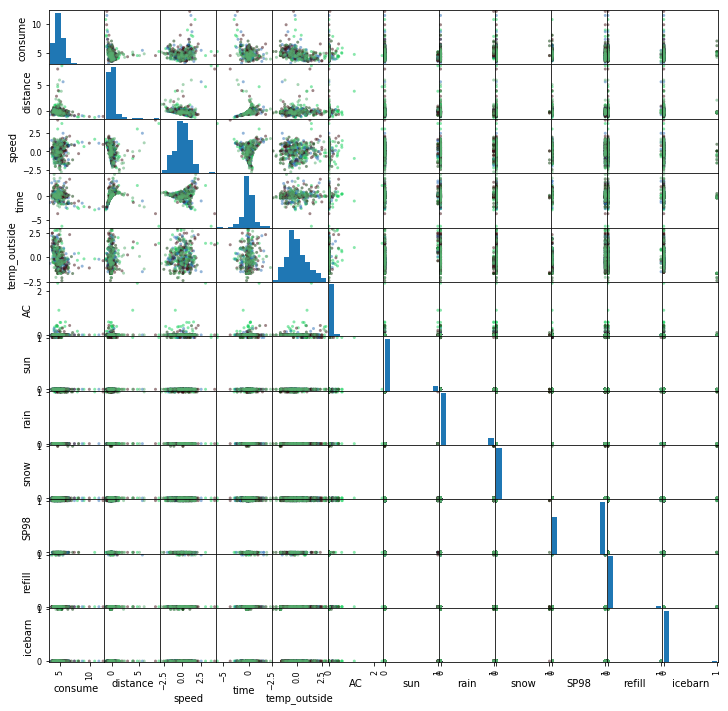

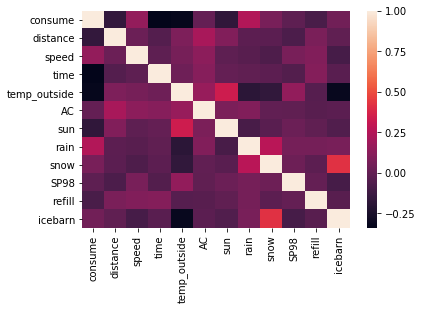

In [247]:
testDataForReg.plot()

,consume,distance,speed,time,temp_outside,AC,sun,rain,snow,SP98,refill,icebarn
count,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000
mean,4.912371,0.007175,0.002477,0.003671,0.000331,0.029834,0.085052,0.123711,0.010309,0.587629,0.033505,0.030928
std,1.033172,1.044251,1.010704,1.021941,1.005439,0.154704,0.279319,0.329677,0.101140,0.492897,0.180184,0.173346
min,3.300000,-0.843320,-2.057586,-1.237067,-2.365708,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.300000,-0.348831,-0.685446,-0.541949,-0.649555,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.700000,-0.207116,-0.099771,-0.252159,-0.192315,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,5.300000,-0.014435,0.569934,0.260832,0.666095,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,12.200000,9.416119,3.575966,7.294447,2.891228,2.338517,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 388 entries, 0 to 76
Data columns (total 12 columns):
consume         388 non-null float64
distance        388 non-null float64
speed           388 non-null float64
time            388 non-null float64
temp_outside    388 non-null float64
AC              388 non-null float64
sun             388 non-null float64
rain            388 non-null float64
snow            388 non-null float64
SP98            388 non-null float64
refill          388 non-null float64
icebarn         388 non-null float64
dtypes: float64(12)
memory usage: 39.4 KB


None

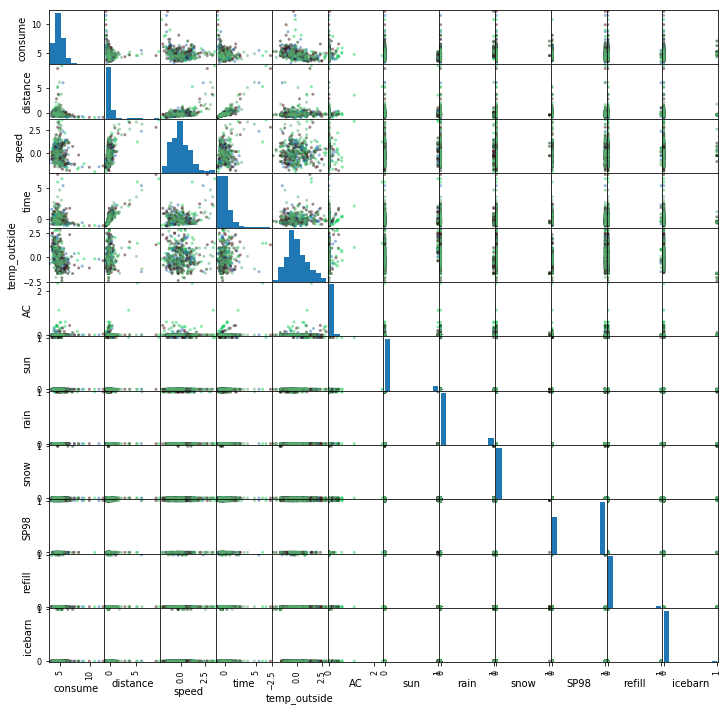

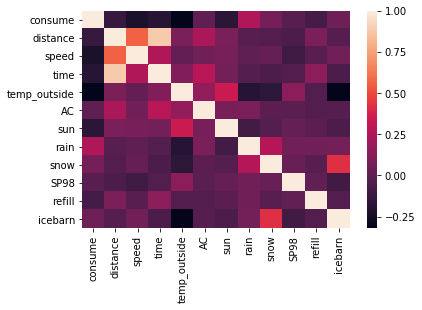

In [248]:
testDataForTree.plot()

# Day2～３でも使用していた線形回帰モデルによるテスト

In [249]:
tuningObject = Tuning()
for testFunc,label in [[linearTest,"Line"],[lassoTest,"L1"],[ridgeTest,"L2"]]:
    tuningObject.gridSearch(testDataForReg,testFunc,
              {"alpha":   np.linspace(1e-10,3,30)**3})
    print("")
    tuningObject.displayBest(label)
for testFunc,label in [[elasticNetTest,"EN"]]:
    tuningObject.gridSearch(testDataForReg,testFunc,
              {"alpha":   np.linspace(1e-10,3,30)**3,
               "l1_ratio":np.linspace(1e-10,1,10),
              })
    print("")
    tuningObject.displayBest(label)



Line


,mse_test,mse_train,alpha
0,0.814807,0.713095,1.000000e-30


Line訓練誤差：0.713
Line汎化誤差：0.815

L1


,mse_test,mse_train,alpha
2,0.777729,0.731545,0.008856


L1訓練誤差：0.732
L1汎化誤差：0.778

L2


,mse_test,mse_train,alpha
17,0.771261,0.723894,5.438968


L2訓練誤差：0.724
L2汎化誤差：0.771

EN


,mse_test,mse_train,alpha,l1_ratio
92,0.772493,0.722147,0.008856,0.333333


EN訓練誤差：0.722
EN汎化誤差：0.772


In [250]:
tuningObject = Tuning()
for testFunc,label in [[linearTest,"Line"],[lassoTest,"L1"],[ridgeTest,"L2"]]:
    tuningObject.gridSearch(testDataForReg2,testFunc,
              {"alpha":   np.linspace(1e-10,3,30)**3})
    print("")
    tuningObject.displayBest(label)
    
for testFunc,label in [[elasticNetTest,"EN"]]:
    tuningObject.gridSearch(testDataForReg2,testFunc,
              {"alpha":   np.linspace(1e-10,3,30)**3,
               "l1_ratio":np.linspace(1e-10,1,10),
              })
    print("")
    tuningObject.displayBest(label)



Line


,mse_test,mse_train,alpha
0,0.801877,0.716115,1.000000e-30


Line訓練誤差：0.716
Line汎化誤差：0.802

L1


,mse_test,mse_train,alpha
2,0.777589,0.731862,0.008856


L1訓練誤差：0.732
L1汎化誤差：0.778

L2


,mse_test,mse_train,alpha
16,0.77245,0.724781,4.534503


L2訓練誤差：0.725
L2汎化誤差：0.772

EN


,mse_test,mse_train,alpha,l1_ratio
92,0.77323,0.724312,0.008856,0.333333


EN訓練誤差：0.724
EN汎化誤差：0.773


In [251]:
tuningObject = Tuning()
for testFunc,label in [[linearTest,"Line"],[lassoTest,"L1"],[ridgeTest,"L2"]]:
    tuningObject.gridSearch(testDataForReg3,testFunc,
              {"alpha":   np.linspace(1e-10,3,30)**3})
    print("")
    tuningObject.displayBest(label)

for testFunc,label in [[elasticNetTest,"EN"]]:
    tuningObject.gridSearch(testDataForReg3,testFunc,
              {"alpha":   np.linspace(1e-10,3,30)**3,
               "l1_ratio":np.linspace(1e-10,1,10),
              })
    print("")
    tuningObject.displayBest(label)



Line


,mse_test,mse_train,alpha
0,0.8185,0.717917,1.000000e-30


Line訓練誤差：0.718
Line汎化誤差：0.818

L1


,mse_test,mse_train,alpha
2,0.780531,0.734514,0.008856


L1訓練誤差：0.735
L1汎化誤差：0.781

L2


,mse_test,mse_train,alpha
18,0.776085,0.729881,6.456353


L2訓練誤差：0.730
L2汎化誤差：0.776

EN


,mse_test,mse_train,alpha,l1_ratio
3,0.77692,0.732731,0.029891,1.000000e-10


EN訓練誤差：0.733
EN汎化誤差：0.777


In [252]:
tuningObject = Tuning()
for testFunc,label in [[linearTest,"Line"],[lassoTest,"L1"],[ridgeTest,"L2"]]:
    tuningObject.gridSearch(testDataForReg4,testFunc,
              {"alpha":   np.linspace(1e-10,3,30)**3})
    print("")
    tuningObject.displayBest(label)

for testFunc,label in [[elasticNetTest,"EN"]]:
    tuningObject.gridSearch(testDataForReg4,testFunc,
              {"alpha":   np.linspace(1e-10,3,30)**3,
               "l1_ratio":np.linspace(1e-10,1,10),
              })
    print("")
    tuningObject.displayBest(label)



Line


,mse_test,mse_train,alpha
0,0.829769,0.711995,1.000000e-30


Line訓練誤差：0.712
Line汎化誤差：0.830

L1


,mse_test,mse_train,alpha
2,0.794823,0.72231,0.008856


L1訓練誤差：0.722
L1汎化誤差：0.795

L2


,mse_test,mse_train,alpha
23,0.78085,0.722696,13.469556


L2訓練誤差：0.723
L2汎化誤差：0.781

EN


,mse_test,mse_train,alpha,l1_ratio
3,0.781727,0.719306,0.029891,1.000000e-10


EN訓練誤差：0.719
EN汎化誤差：0.782


# データの前処理
### ・標準化、白色化
##### 　・Lassoではダミー変数を含め標準化した方が精度が上がる
##### 　・Ridgeではダミー変数を除いて標準化した方が精度が上がる
##### 　・Ridgeでは白色化した方が精度が上がる
### ・特徴選択
##### 　・手作業で特徴選択した場合、精度が落ちた
##### 　　ステップワイズ法などを使用しない、単純なモデル作成の場合は全て入れてよい
##### 　・変数同士の関係性を別の変数として追加しても精度が向上する
##### 　・不要な物、今回でいうならばtemp_insideを破棄しても影響は無い

# 追加した特徴値の有意性
### 　AC > AC_raw
### 　refill 僅かに貢献
### 　time 大きく貢献
### 　icebarn 僅かな悪影響
### 　snow 関係性がほぼ無い

# ここまでがDay2、3の再調整
#### 　・単項式線形回帰モデルに対し、Day3時点のデータに特徴値として
#### 　　給油有無と所要時間を追加した事で精度が向上している事を確認
#### 　　所要時間の追加が影響大きく汎化性能が0.1向上している
#### 　　給油有無は僅かに影響し、汎化性能が0.01向上している
#### 　　遷移としては以下
##### 　　Day2提出時のモデル　→　訓練誤差と汎化誤差が逆転しており、論外
##### 　　Day3提出時のモデル　→　単項式Ridge　汎化性能MSE0.91
##### 　　Day4予習時のモデル　→　単項式Ridge　汎化性能MSE0.78

# Day3提出時から調整している
# 多項式回帰、木モデル、アンサンブル学習のテスト

In [253]:
import re

alphaArray    = np.linspace(0.1,3,20) ** 3
l1ratioArray  = np.linspace(0.001,1,5)
mxdArray      = np.unique(np.append(np.arange(2,16,3),np.arange(8,12)))
mslArray      = np.arange(2,7) ** 2
mssArray      = np.arange(2,7) ** 2 * 2
degreeArray   = np.arange(1,4)
adaboostArray = np.arange(1,31,10)

tuningObjectArray = []

for testFunc,label in [
                        [PolynominalLineTest,"PolynominalLine"],
                        [PolynominalL1Test,"PolynominalL1"],
                        [PolynominalL2Test,"PolynominalL2"],
                        [PolynominalENTest,"PolynominalEN"],
                        [adbL1Test,"AdaL1"],
                        [adbL2Test,"AdaL2"],
                        [adbENTest,"AdaEN"],
                        [AdaPolynominalL1Test,"AdaPolynominalL1"],
                        [AdaPolynominalL2Test,"AdaPolynominalL2"],
# 処理が重たすぎて帰ってこないため分離
#                         [AdaPolynominalENTest,"AdaPolynominalEN"],
#                         [DTregTest,"DT"],
#                         [RFregTest,"RF"],
#                         [PolynominalDTTest,"PolynominalDT"],
#                         [PolynominalRFTest,"PolynominalRF"],
#                         [adbDTTest,"AdaDT"],
#                         [adbRFTest,"AdaRF"],
#                         [AdaPolynominalDTTest,"AdaPolynominalDT"],
#                         [AdaPolynominalRFTest,"AdaPolynominalRF"],
                      ]:
    
    hyperParam = {}
    ret = re.search("..$",label)
    if ret != None:
        funcType = label[ret.span()[0]:ret.span()[1]]
        if funcType == "L1" or funcType == "L2" or funcType == "EN":
            hyperParam["alpha"]             = alphaArray
        if funcType == "EN":
            hyperParam["l1_ratio"]          = l1ratioArray
        if funcType == "DT" or funcType == "RF":
            hyperParam["max_depth"]         = mxdArray
            hyperParam["min_samples_leaf"]  = mslArray
            hyperParam["min_samples_split"] = mssArray
            testSet = testDataForTree
        else:
            testSet = testDataForReg
            
    ret = re.search("Polynominal",label)
    if ret != None:
        hyperParam["degree"]                = degreeArray
        
    ret = re.search("^Ada",label)
    if ret != None:
        hyperParam["ada_n_estimators"]      = adaboostArray
    
    tuningObj = Tuning()
    tuningObjectArray.append(tuningObj)
    tuningObj.gridSearch(testSet,testFunc,hyperParam)
    print("")
    tuningObj.displayBest(label)



PolynominalLine


,mse_test,mse_train,degree
0,0.814807,0.713095,1.0


PolynominalLine訓練誤差：0.713
PolynominalLine汎化誤差：0.815

PolynominalL1


,mse_test,mse_train,alpha,degree
42,0.541981,0.41986,0.06656,3.0


PolynominalL1訓練誤差：0.420
PolynominalL1汎化誤差：0.542

PolynominalL2


,mse_test,mse_train,alpha,degree
39,0.579891,0.424348,27.0,2.0


PolynominalL2訓練誤差：0.424
PolynominalL2汎化誤差：0.580

PolynominalEN


,mse_test,mse_train,alpha,l1_ratio,degree
262,0.52294,0.401714,0.06656,0.75025,3.0


PolynominalEN訓練誤差：0.402
PolynominalEN汎化誤差：0.523

AdaL1


,mse_test,mse_train,alpha,ada_n_estimators
1,0.787348,0.753603,0.016124,1.0


AdaL1訓練誤差：0.754
AdaL1汎化誤差：0.787

AdaL2


,mse_test,mse_train,alpha,ada_n_estimators
10,0.771115,0.736771,4.301448,1.0


AdaL2訓練誤差：0.737
AdaL2汎化誤差：0.771

AdaEN


,mse_test,mse_train,alpha,l1_ratio,ada_n_estimators
1,0.77126,0.737448,0.016124,0.001,1.0


AdaEN訓練誤差：0.737
AdaEN汎化誤差：0.771

AdaPolynominalL1


,mse_test,mse_train,alpha,degree,ada_n_estimators
21,0.633241,0.496899,0.016124,2.0,1.0


AdaPolynominalL1訓練誤差：0.497
AdaPolynominalL1汎化誤差：0.633

AdaPolynominalL2


,mse_test,mse_train,alpha,degree,ada_n_estimators
39,0.603074,0.470806,27.0,2.0,1.0


AdaPolynominalL2訓練誤差：0.471
AdaPolynominalL2汎化誤差：0.603


In [217]:
import re

# alphaArray    = np.linspace(0.1,3,20) ** 3
# l1ratioArray  = np.linspace(0.001,1,5)
# mxdArray      = np.unique(np.append(np.arange(2,16,3),np.arange(8,12)))
# mslArray      = np.arange(2,7) ** 2
# mssArray      = np.arange(2,7) ** 2 * 2
# degreeArray   = np.arange(1,4)
# adaboostArray = np.arange(1,31,10)

# 探索パターン数を削減する
alphaArray    = np.linspace(0.1,3,20) ** 3
l1ratioArray  = np.linspace(0.001,1,5)
mxdArray      = np.unique(np.append(np.arange(2,16,3),np.arange(8,12)))
mslArray      = np.arange(2,7) ** 2
mssArray      = np.arange(2,7) ** 2 * 2
degreeArray   = np.arange(1,4)
adaboostArray = np.array([1,10])

tuningObjectArray = []

for testFunc,label in [
#                         [PolynominalLineTest,"PolynominalLine"],
#                         [PolynominalL1Test,"PolynominalL1"],
#                         [PolynominalL2Test,"PolynominalL2"],
#                         [PolynominalENTest,"PolynominalEN"],
#                         [adbL1Test,"AdaL1"],
#                         [adbL2Test,"AdaL2"],
#                         [adbENTest,"AdaEN"],
#                         [AdaPolynominalL1Test,"AdaPolynominalL1"],
#                         [AdaPolynominalL2Test,"AdaPolynominalL2"],
                        [AdaPolynominalENTest,"AdaPolynominalEN"],
                        [DTregTest,"DT"],
                        [RFregTest,"RF"],
                        [PolynominalDTTest,"PolynominalDT"],
                        [PolynominalRFTest,"PolynominalRF"],
                        [adbDTTest,"AdaDT"],
                        [adbRFTest,"AdaRF"],
                        [AdaPolynominalDTTest,"AdaPolynominalDT"],
                        [AdaPolynominalRFTest,"AdaPolynominalRF"],
                      ]:
    
    hyperParam = {}
    ret = re.search("..$",label)
    if ret != None:
        funcType = label[ret.span()[0]:ret.span()[1]]
        if funcType == "L1" or funcType == "L2" or funcType == "EN":
            hyperParam["alpha"]             = alphaArray
        if funcType == "EN":
            hyperParam["l1_ratio"]          = l1ratioArray
        if funcType == "DT" or funcType == "RF":
            hyperParam["max_depth"]         = mxdArray
            hyperParam["min_samples_leaf"]  = mslArray
            hyperParam["min_samples_split"] = mssArray
            testSet = testDataForTree
        else:
            testSet = testDataForReg
            
    ret = re.search("Polynominal",label)
    if ret != None:
        hyperParam["degree"]                = degreeArray
        
    ret = re.search("^Ada",label)
    if ret != None:
        hyperParam["ada_n_estimators"]      = adaboostArray
    
    tuningObj = Tuning()
    tuningObjectArray.append(tuningObj)
    tuningObj.gridSearch(testSet,testFunc,hyperParam)
    print("")
    tuningObj.displayBest(label)



AdaPolynominalEN


,mse_test,mse_train,alpha,l1_ratio,degree,ada_n_estimators
104,0.585411,0.480953,0.358708,0.001,2.0,1.0


AdaPolynominalEN訓練誤差：0.481
AdaPolynominalEN汎化誤差：0.585

DT


,mse_test,mse_train,max_depth,min_samples_leaf,min_samples_split
37,0.495515,0.310172,8.0,4.0,18.0


DT訓練誤差：0.310
DT汎化誤差：0.496

RF


,mse_test,mse_train,max_depth,min_samples_leaf,min_samples_split
6,0.416585,0.237397,14.0,4.0,8.0


RF訓練誤差：0.237
RF汎化誤差：0.417

PolynominalDT


,mse_test,mse_train,max_depth,min_samples_leaf,min_samples_split,degree
37,0.487977,0.302592,8.0,4.0,18.0,1.0


PolynominalDT訓練誤差：0.303
PolynominalDT汎化誤差：0.488

PolynominalRF


,mse_test,mse_train,max_depth,min_samples_leaf,min_samples_split,degree
3,0.417693,0.243039,9.0,4.0,8.0,1.0


PolynominalRF訓練誤差：0.243
PolynominalRF汎化誤差：0.418

AdaDT


,mse_test,mse_train,max_depth,min_samples_leaf,min_samples_split,ada_n_estimators
185,0.474823,0.153057,9.0,9.0,8.0,10.0


AdaDT訓練誤差：0.153
AdaDT汎化誤差：0.475

AdaRF


,mse_test,mse_train,max_depth,min_samples_leaf,min_samples_split,ada_n_estimators
181,0.446859,0.101459,14.0,4.0,8.0,10.0


AdaRF訓練誤差：0.101
AdaRF汎化誤差：0.447

AdaPolynominalDT


,mse_test,mse_train,max_depth,min_samples_leaf,min_samples_split,degree,ada_n_estimators
533,0.473188,0.21983,5.0,9.0,8.0,1.0,10.0


AdaPolynominalDT訓練誤差：0.220
AdaPolynominalDT汎化誤差：0.473

AdaPolynominalRF


,mse_test,mse_train,max_depth,min_samples_leaf,min_samples_split,degree,ada_n_estimators
527,0.447891,0.122799,8.0,4.0,8.0,1.0,10.0


AdaPolynominalRF訓練誤差：0.123
AdaPolynominalRF汎化誤差：0.448


# Day3予習時のモデルの再調整
##### 　・多項式回帰モデルと決定木モデルを作成し評価
##### 　　多項式回帰を実施した場合、単項式回帰の場合より精度が向上している事を確認
##### 　　Day3提出時
##### 　　　単項式L2　0.91　→　多項式L2　0.86
##### 　　Day4予習時
##### 　　　単項式EN　0.78　→　多項式EN　0.5　単一の決定木回帰と見劣りせず
##### 　　　テストデータを含め無相関化していたため
##### 　　　テストデータを除いたデータセットに修正
##### 　　　無相関化調整後のデータでは多項式ENで誤差が0.52
##### 　　　　エアコンのダミー変数を時間係数と同等にしたため、性能下落が小さく済んでいる
##### 　　　　ハイパーパラメーターの再調整で、無相関化調整前と同程度の性能まで改善
# 　


##### 　・決定木、ランダムフォレストを作成し評価
##### 　　チューニングせずに実装しても線形回帰モデルより高い精度を誇る事を確認
##### 　　Day3提出時
##### 　　　チューニング無し
##### 　　　　決定木　　　0.81
##### 　　　　RF(ランダムフォレスト)　0.6前後　
##### 　　　チューニング有り
##### 　　　　Ada決定木　0.64
##### 　　　　RF   　　　  0.47
##### 　　Day4予習時
##### 　　　　Ada決定木　0.49
##### 　　　　RF   　　　  0.38　※leafとn_estimatorsのチューニングを追加
##### 　　　　乱択RF   　  0.38　※n_estimatorsを設定せず、乱数制御無しで10試行した場合

# Boosting批評
###### 　Boostingを行う場合、内部制御に乱数の関わらない物が望ましい
###### 　　Boostingの有意性　決定木　＞　ランダムフォレスト（BootstrapのせいでBoostingが台無し）
###### 　線形回帰モデルにBoostingを行う必要性は無い、少なくともAdaboostは逆効果である
###### 　　Boostingの効果　複雑なモデル　＞　簡単なモデル

# 線形回帰モデルと木モデルから成績の良いものを選抜し
# パラメーターの再調整を実施

,mse_test,mse_train,max_depth,min_samples_leaf,min_samples_split,n_estimators
58,0.392564,0.194596,12.0,3.0,2.0,20.0


訓練誤差：0.195
汎化誤差：0.393
Optimized max_depth：12.0


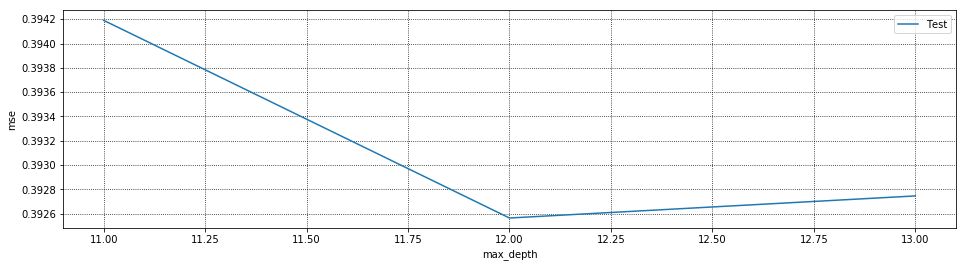


Optimized min_samples_leaf：3.0


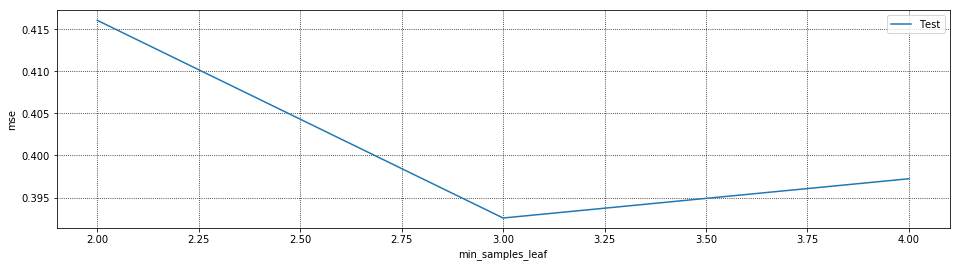


Optimized min_samples_split：2.0


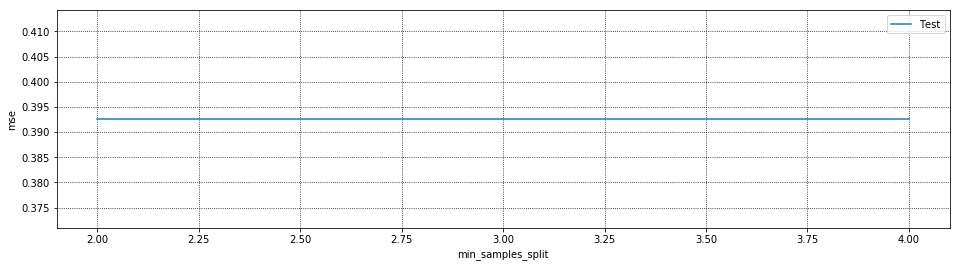


Optimized n_estimators：20.0


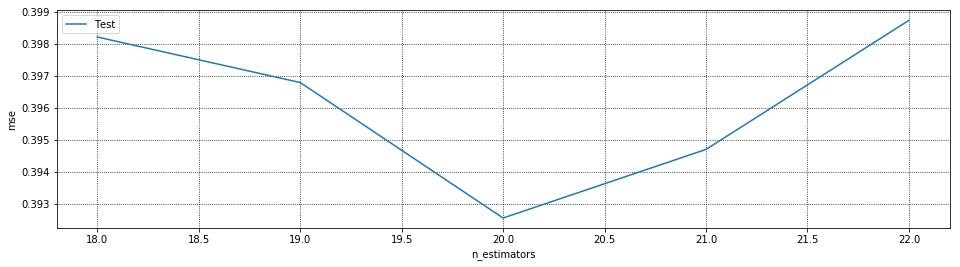

In [230]:
# min_sample_leaf splitで調整した場合、汎化性能が上がることを確認
tuningObject = Tuning()
result = tuningObject.gridSearch(testDataForTree,RFregTest,
          {"max_depth":           np.arange(11,14,1),
            "min_samples_leaf":   np.arange(2,5,1),
            "min_samples_split":  np.arange(2,5,1),
            "n_estimators":       np.arange(18,23),
          })
tuningObject.showGraph(_Train=False)

,mse_test,mse_train,alpha,l1_ratio,degree
145,0.505239,0.353635,0.177111,0.058889,3.0


訓練誤差：0.354
汎化誤差：0.505
Optimized alpha：0.1771111111111111


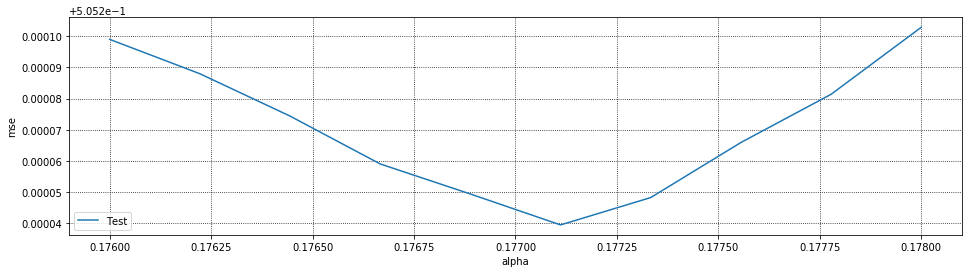


Optimized l1_ratio：0.05888888888888889


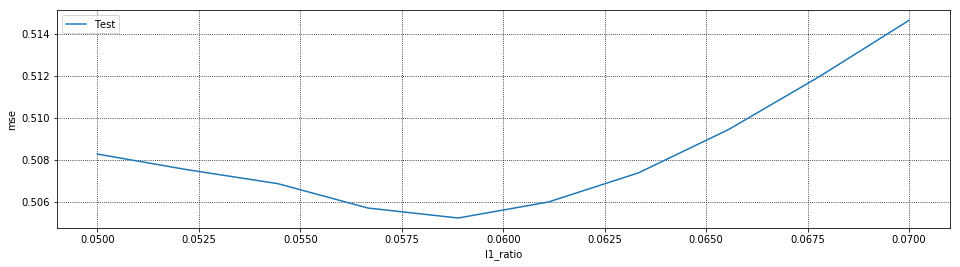


Optimized degree：3.0


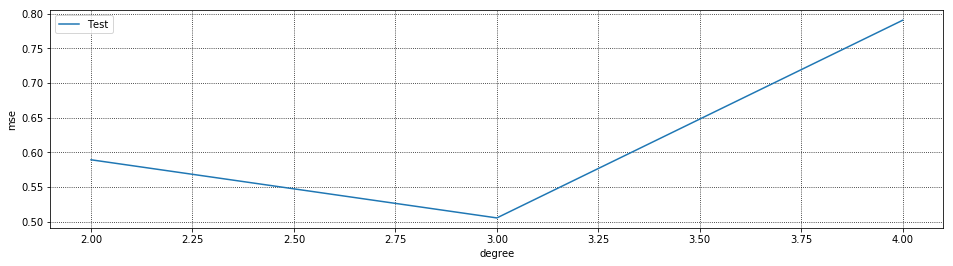

In [270]:
tuningObject = Tuning()
result = tuningObject.gridSearch(testDataForReg,PolynominalENTest,
          { "alpha":   np.linspace(0.176,0.178,10),
            "l1_ratio":np.linspace(0.05,0.07,10),
            "degree":  np.arange(2,5),
          })
tuningObject.showGraph(_Train=False)

,mse_test,mse_train,repeat,max_depth,min_samples_leaf,min_samples_split
510,0.385241,0.210934,1.0,9.0,3.0,4.0


訓練誤差：0.211
汎化誤差：0.385
Optimized repeat：1.0


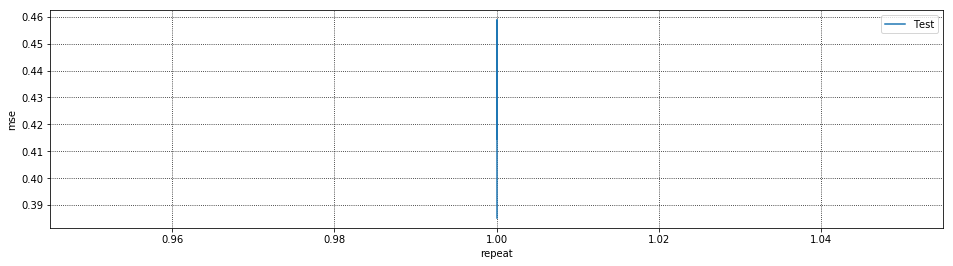


Optimized max_depth：9.0


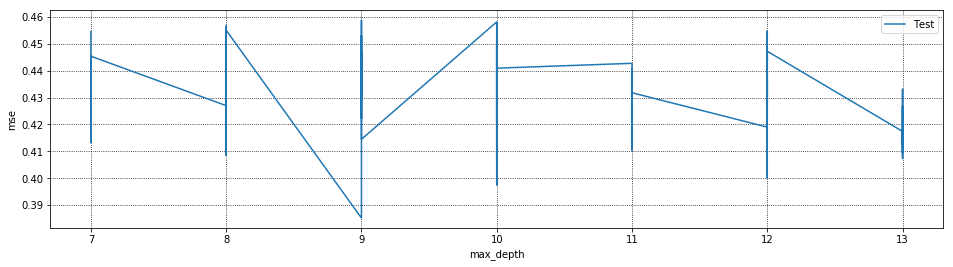


Optimized min_samples_leaf：3.0


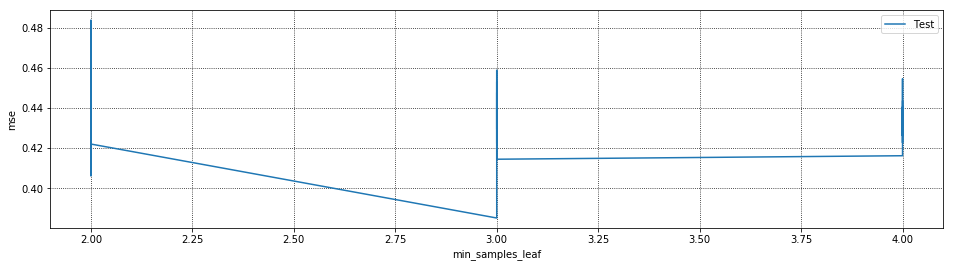


Optimized min_samples_split：4.0


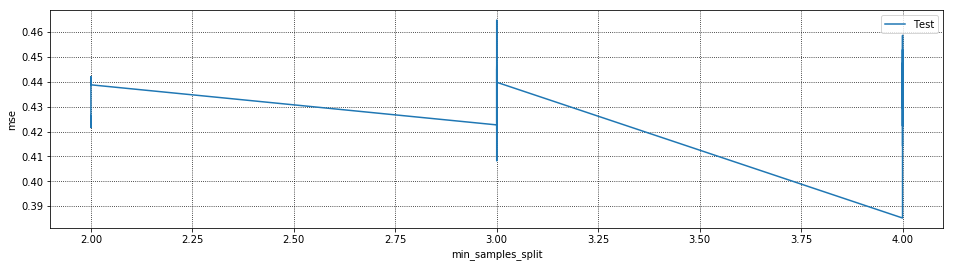

In [221]:
# 乱数不定版、ランダムフォレストで乱数を自由設定にした場合が汎化性能が高い物が生成された
# おそらくBootstrap変化に影響を受けている、単純に試行回数を増やしてテストする
tuningObject = Tuning()
result = tuningObject.gridSearch(testDataForTree,RFregTestNorand,
          { "repeat": np.ones(10),
            "max_depth":          np.arange(7,14),
            "min_samples_leaf":   np.array([2,3,4]),
            "min_samples_split":  np.array([2,3,4]),
          })
tuningObject.showGraph(_Train=False)

# 回帰モデル、木モデル調査結果
### 　・ランダムフォレスト回帰が最も良い成績を収める
### 　　また、ランダムフォレスト回帰を行う場合、無相関化を行わない方が精度が上がっている
### 　・単純な回帰の場合、PolynominalのDegree2辺りでElasticNetを使うとそれなりに精度が上がった
### 　　ただし、木モデルには及ばず、グラフ化あるいは補助変数生成に使用する事を検討
### 　・乱数不定版で試行回数を増やし乱択してもそれなりに精度の高いモデルが出現する
### 　　これはグリッドサーチをランダムサーチにするのと同じ所以

In [226]:
# min_sample_leaf splitで調整した場合、汎化性能が上がることを確認
tuningObject = Tuning()
result = tuningObject.gridSearch(testDataForTree,RFregTest,
          {"max_depth":           np.arange(11,12),
            "min_samples_leaf":   np.arange(3,4),
            "min_samples_split":  np.arange(2,3),
            "n_estimators":       np.arange(20,21),
          })
tuningObject.displayBest()

,mse_test,mse_train,max_depth,min_samples_leaf,min_samples_split,n_estimators
0,0.394191,0.195575,11.0,3.0,2.0,20.0


訓練誤差：0.196
汎化誤差：0.394


In [269]:
tuningObject = Tuning()
result = tuningObject.gridSearch(testDataForReg,PolynominalENTest,
          { "alpha":   np.array([0.177333]),
            "l1_ratio":np.array([0.058889]),
            "degree":  np.array([3]),
          })
tuningObject.displayBest()

,mse_test,mse_train,alpha,l1_ratio,degree
0,0.505248,0.353693,0.177333,0.058889,3.0


訓練誤差：0.354
汎化誤差：0.505


,mse_test,mse_train,repeat,max_depth,min_samples_leaf,min_samples_split
137,0.392037,0.202599,1.0,13.0,3.0,2.0


訓練誤差：0.203
汎化誤差：0.392
Optimized repeat：1.0


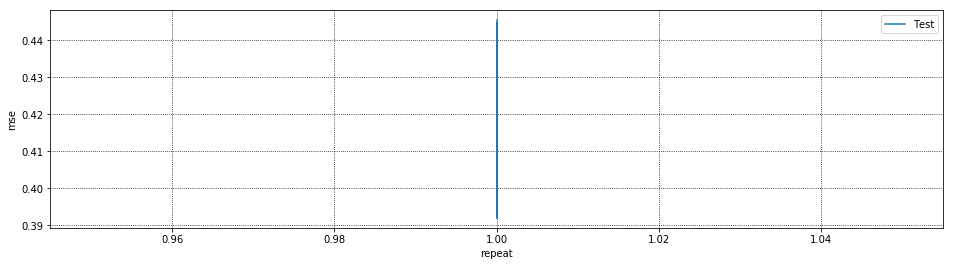


Optimized max_depth：13.0


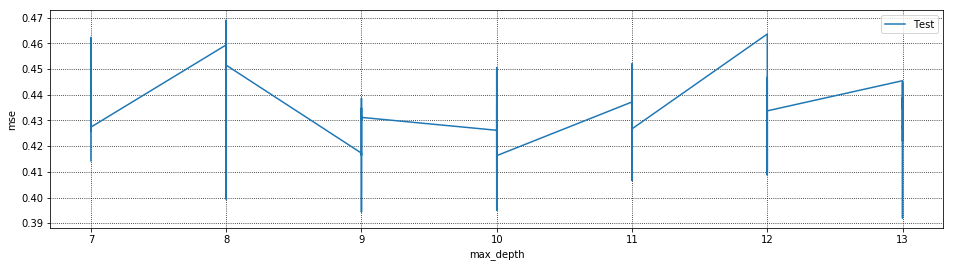


Optimized min_samples_leaf：3.0


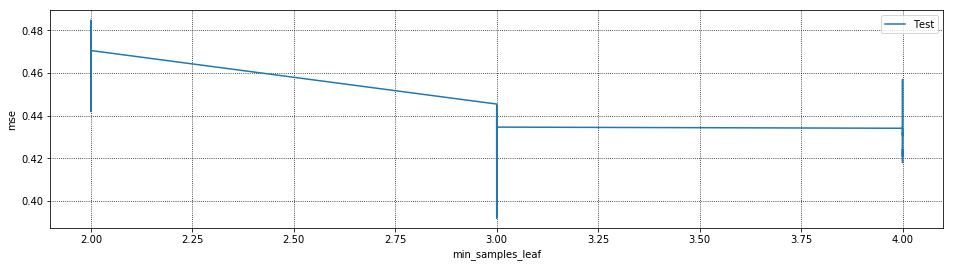


Optimized min_samples_split：2.0


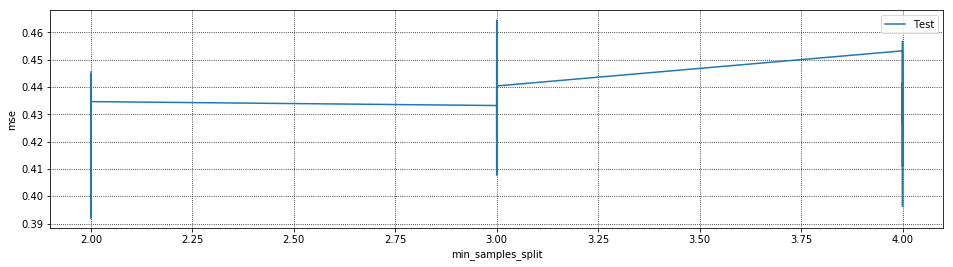

In [228]:
# 乱数不定版、ランダムフォレストで乱数を自由設定にした場合が汎化性能が高い物が生成された
# おそらくBootstrap変化に影響を受けている、単純に試行回数を増やしてテストする
tuningObject = Tuning()
result = tuningObject.gridSearch(testDataForTree,RFregTestNorand,
          { "repeat": np.ones(10),
            "max_depth":          np.arange(7,14),
            "min_samples_leaf":   np.array([2,3,4]),
            "min_samples_split":  np.array([2,3,4]),
          })
tuningObject.showGraph(_Train=False)

# 検討作業
###### 　criterionは変更していない、勾配Boostingは使用していない、ML4の後に実施する、先にNNの検証を行う
###### 　線形回帰モデルの予測結果を特徴値として取り込んで決定木モデルを実行するパターン(PipeLineとは別？)
# TODO
###### 　TODO１：NN検証
###### 　TODO２：サーチモデルの所要時間と試行回数表示拡張　※内部モデルが多い物は所要時間が10倍、100倍になる為
###### 　　　　　→　コードのみ作成、未テスト
###### 　TODO３：木モデルのcriterion変更確認
###### 　TODO４：勾配Boostingの確認
###### 　TODO５：簡易モデルの予測結果取り込み


# NN系の調査

In [305]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from IPython.display import display
import seaborn as sns
from sklearn.metrics import mean_squared_error
from tensorflow import keras  
import tensorflow as tf


In [351]:
print(len(tfmodelArray))
print(tfmodelArray)

10
[<tensorflow.python.keras.engine.sequential.Sequential object at 0x0000000021B42BA8>, <tensorflow.python.keras.engine.sequential.Sequential object at 0x000000002AA99668>, <tensorflow.python.keras.engine.sequential.Sequential object at 0x000000002F8F2940>, <tensorflow.python.keras.engine.sequential.Sequential object at 0x0000000030FF6A58>, <tensorflow.python.keras.engine.sequential.Sequential object at 0x000000002AFB5FD0>, <tensorflow.python.keras.engine.sequential.Sequential object at 0x00000000329CC588>, <tensorflow.python.keras.engine.sequential.Sequential object at 0x00000000329CC240>, <tensorflow.python.keras.engine.sequential.Sequential object at 0x0000000034336668>, <tensorflow.python.keras.engine.sequential.Sequential object at 0x000000002E4E0358>, <tensorflow.python.keras.engine.sequential.Sequential object at 0x000000003866EA58>]


In [446]:
from tensorflow.compat.v1.keras import Sequential
from tensorflow.compat.v1.keras.layers import Dense, Dropout, Activation
from tensorflow.compat.v1.keras.optimizers import SGD,RMSprop, Adagrad, Adadelta, Adam

# class MySequential(Sequential):
#     def __init__(self,):
#         Sequential
#     def fit(self):
modelNumber = len(tfmodelArray)
tfmodelArray.append(Sequential())
tfmodel = tfmodelArray[modelNumber]
tfmodel.add(Dense(11,activation="relu",input_dim=11))
tfmodel.add(Dense(14,activation="relu"))
tfmodel.add(Dropout(rate=0.05))
tfmodel.add(Dense(11,activation="relu"))
tfmodel.add(Dense(8,activation="relu"))
tfmodel.add(Dense(11,activation="relu",input_dim=11))
tfmodel.add(Dense(14,activation="relu"))
tfmodel.add(Dropout(rate=0.05))
tfmodel.add(Dense(11,activation="relu"))
tfmodel.add(Dense(8,activation="relu"))
tfmodel.add(Dense(11,activation="relu",input_dim=11))
tfmodel.add(Dense(14,activation="relu"))
tfmodel.add(Dropout(rate=0.05))
tfmodel.add(Dense(11,activation="relu"))
tfmodel.add(Dense(8,activation="relu"))
tfmodel.add(Dense(4,activation="relu"))
tfmodel.add(Dense(1))# 回帰系はカテゴリ確率ではなく最終値を取る, activation='softmax'))#最終層のactivationは変更しないこと

# ------ 最適化手法 ------
sgd = SGD(lr=0.01, momentum=0.9, nesterov=False)
# rms = RMSprop(lr=0.01)
rmp = RMSprop(learning_rate=0.1, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False, name='RMSprop')# adag = Adagrad(lr=0.01)
# adad = Adadelta(lr=0.01)
adam = Adam(lr=0.01)
# -----------------------------

tfmodel.compile(loss='mse',
              optimizer=adam,
               metrics=["mse"]) # , 'mae', 'mape', 'cosine'

# WARNINGが出るが気にしなくて良い

Train on 310 samples, validate on 78 samples
Epoch 1/30
310/310 [==============================] - 3s 9ms/sample - loss: 24.6493 - mean_squared_error: 24.6493 - val_loss: 21.1754 - val_mean_squared_error: 21.1754
Epoch 2/30
310/310 [==============================] - 0s 145us/sample - loss: 19.3659 - mean_squared_error: 19.3659 - val_loss: 10.1863 - val_mean_squared_error: 10.1863
Epoch 3/30
310/310 [==============================] - 0s 177us/sample - loss: 6.6941 - mean_squared_error: 6.6941 - val_loss: 1.4229 - val_mean_squared_error: 1.4229
Epoch 4/30
310/310 [==============================] - 0s 216us/sample - loss: 3.4505 - mean_squared_error: 3.4505 - val_loss: 2.0764 - val_mean_squared_error: 2.0764
Epoch 5/30
310/310 [==============================] - 0s 177us/sample - loss: 2.2917 - mean_squared_error: 2.2917 - val_loss: 0.5536 - val_mean_squared_error: 0.5536
Epoch 6/30
310/310 [==============================] - 0s 168us/sample - loss: 1.4466 - mean_squared_error: 1.4466 - val

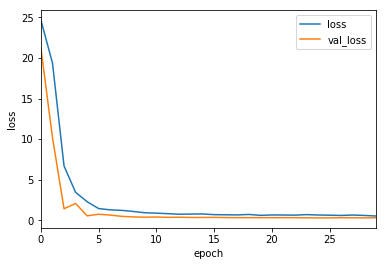

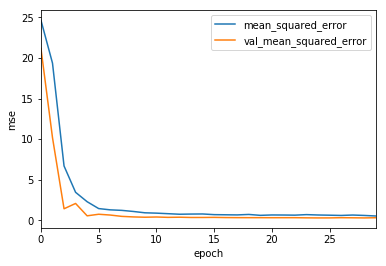

In [447]:
# 計算の実行、テストデータとして回帰モデル向けの無相関データより木モデル向けの元データが効果的
# 学習に際して、batch_sizeの値は途中変更しても悪影響しかなさそう
testDataNN = holdOutTest(X,y,randomValue,scalerNormal)
X_train = testDataNN.X_train
y_train = testDataNN.y_train
X_test  = testDataNN.X_test
y_test  = testDataNN.y_test

fit = tfmodel.fit(X_train, y_train,
          epochs=30,
          batch_size=len(X_train)//5,validation_data=(X_test, y_test))

# 各epochにおける損失と精度をdfに入れる
df = pd.DataFrame(fit.history)

# グラフ化
df[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

df[["mean_squared_error","val_mean_squared_error"]].plot()
plt.ylabel("mse")
plt.xlabel("epoch")
plt.show()

In [425]:
# 三宅さんソースのコピー、参考にしてグラフ化してみる予定
# plt.scatter(target_test, target_test)
# plt.scatter(target_test, day2_result, label='day2')
# plt.xlim(target.min(), target.max()+1)
# plt.ylim(target.min(), target.max()+1)
# plt.xlabel("target")
# plt.ylabel("predict")
# plt.legend()
# plt.show()

# plt.scatter(target_test, target_test)
# plt.scatter(target_test, forest_gs_result, label='random_forest')
# plt.xlim(target.min(), target.max()+1)
# plt.ylim(target.min(), target.max()+1)
# plt.xlabel("target")
# plt.ylabel("predict")
# plt.legend()
# plt.show()

# plt.scatter(target_test, target_test)
# plt.scatter(target_test, model2.predict(data_test), label=('neural_net'))
# plt.xlim(target.min(), target.max()+1)
# plt.ylim(target.min(), target.max()+1)
# plt.xlabel("target")
# plt.ylabel("predict")
# plt.legend()
# plt.show()

In [394]:
y_pred = fit.model.predict(X_test)
pd.DataFrame(y_pred,columns=[["consume"]])

,consume
0,4.386285
1,4.041942
2,5.075438
3,4.690813
4,4.238747
5,4.268259
6,4.725144
7,4.285449
8,5.083821
9,4.616021
